# Seed Words with K-Means

TODO: use UMAP

TODO: intersect comment and fine-tuning vocab

**for Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/group-1.3/JupyterNotebook

Mounted at /content/drive
/content/drive/MyDrive/group-1.3/JupyterNotebook


In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!pip install yellowbrick

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

In [2]:
num_clusters = 10
num_seed_words = 15
num_plot = 10

# load word vectors

In [3]:
def process_text(text_list, lemmatize=True, stop_words=None):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_text = [s.lower() for s in text_list]
    tokenized_text = [tokenizer.tokenize(s) for s in tokenized_text]
    processed_text = []
    for tokens in tqdm(tokenized_text):
        if stop_words != None:
            tokens = [token for token in tokens if token not in stop_words]
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        processed_text.append(tokens)
    return processed_text

In [4]:
comment_file = "../processed/comments.pkl"
df_comment = pd.read_pickle(comment_file)
comment_list = df_comment.comment.astype('str').tolist()
comments = process_text(comment_list, lemmatize=True)

100%|██████████| 135479/135479 [00:27<00:00, 4888.44it/s]


In [5]:
print(comments[0])

['that', 'wa', 'another', 'administration']


In [6]:
model = Word2Vec(size=300)
model.build_vocab(comments)
total_examples = model.corpus_count

In [7]:
model.intersect_word2vec_format("../wv/w2v_corpus_trained.bin", binary=True)
print(model.wv.vectors.shape)

(20908, 300)


In [8]:
%%time
# load specific word embeddings that you want 
# w2v_model = Word2Vec.load('../wv/w2v_comment_raw.model')
# w2v_model = Word2Vec.load('../wv/w2v_comment_trained.model')
# w2v_model = Word2Vec.load('../wv/w2v_comment_stopword_trained.model')
# w2v = w2v_model.wv.vectors
w2v_keyedvector = KeyedVectors.load_word2vec_format('../wv/w2v_corpus_trained.bin', binary=True)
w2v = w2v_keyedvector.vectors
n_words = w2v.shape[0]

Wall time: 415 ms


In [9]:
print(n_words)

19379


## elbow method

https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/

In [18]:
%%time
kmeans = KMeans()
visualizer_1 = KElbowVisualizer(kmeans, k=(2,40))
visualizer_1.fit(w2v)
visualizer_1.show(outpath='../output/kmeans_elbow_yb_1.png')
# will give different results from multiple experiments

KeyboardInterrupt: 

Wall time: 11min 9s


<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

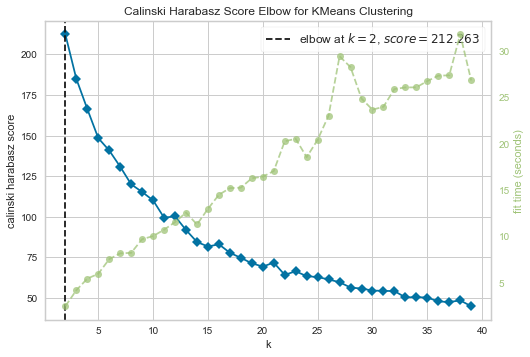

In [19]:
%%time
kmeans = KMeans()
visualizer_2 = KElbowVisualizer(kmeans, k=(2,40), metric='calinski_harabasz')
visualizer_2.fit(w2v)
visualizer_2.show(outpath='../output/kmeans_elbow_yb_2.png')

In [ ]:
cost = []
for i in tqdm(range(2, 40)):
    kmeans = KMeans(n_clusters=i, max_iter=500)
    kmeans.fit(w2v)
    cost.append(kmeans.inertia_)
# range(2, 60) takes about 40 minutes

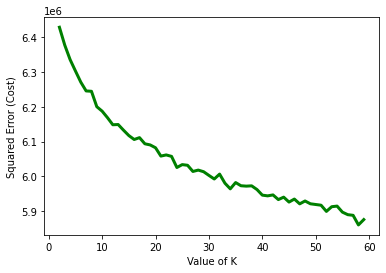

In [ ]:
plt.plot(range(2, 60), cost, color='g', linewidth='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.savefig("../output/kmeans_elbow.png")
plt.show()

## AIC and BIC

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [ ]:
n_components = np.arange(1, 21)
bic_list = []
aic_list = []
for n in tqdm(n_components):
    gmm = GaussianMixture(n, covariance_type='full', random_state=0, init_params='kmeans').fit(w2v)
    gmm_bic = gmm.bic(w2v)
    gmm_aic = gmm.aic(w2v)
    bic_list.append(gmm_bic)
    aic_list.append(gmm_aic)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(w2v) for n in tqdm(n_components)]

100%|██████████| 20/20 [29:57<00:00, 89.89s/it] 


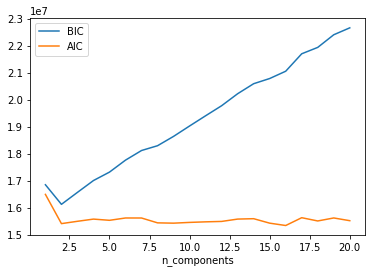

In [ ]:
plt.plot(n_components, bic_list, label='BIC')
plt.plot(n_components, aic_list, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.savefig('../output/kmeans_aic_bic.png')

# K-means

In [ ]:
%%time
kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1, random_state=0)
cluster_idx = kmeans.fit_predict(w2v)
X_dist = kmeans.transform(w2v)**2   # [N, n_clusters]
X_dist_cluster = X_dist[range(n_words), cluster_idx]    # distance away from corresponding centroid

CPU times: user 242 ms, sys: 173 ms, total: 415 ms
Wall time: 14.7 s


In [ ]:
print(cluster_idx)
print(X_dist[:5])
print(X_dist_cluster[:5])
print((cluster_idx == kmeans.labels_).all())

[0 3 3 ... 3 1 1]
[[208.72101 225.08922 226.19789 213.06813 265.1689  294.83713 255.75027
  272.09488 262.09134 274.20163]
 [451.66367 472.45386 451.00052 435.09085 475.6838  583.727   470.6879
  462.27173 531.6476  466.51205]
 [135.11244 164.30139 171.82773 133.53827 172.4332  214.78923 166.09163
  195.01164 202.18633 156.5289 ]
 [258.99155 257.24326 254.91312 235.9373  278.09003 309.3896  280.3549
  295.22733 291.9612  261.03262]
 [454.32364 483.31653 436.44476 433.7102  514.3466  452.88437 474.84528
  457.01303 518.7499  491.5462 ]]
[208.72101 435.09085 133.53827 235.9373  433.7102 ]
True


In [ ]:
print(kmeans.cluster_centers_)

[[-0.05252196  0.47024286 -0.29505342 ... -0.16681275  0.1865545
  -0.27060467]
 [-0.26870197 -0.03184704 -0.40419367 ... -0.27638927 -0.09230246
   0.19173594]
 [ 0.3995991   0.12756874  0.28574267 ...  0.25334084 -0.09438137
   0.48294067]
 ...
 [ 0.36009973 -0.23608205 -0.19741973 ... -0.2958171  -0.15401468
   0.37800327]
 [-0.45125437  0.46965516  0.5002633  ... -0.24498597  0.25615534
   0.5242446 ]
 [-0.26039016 -0.07721036  0.4384427  ... -0.09748468  0.3996206
  -0.12630224]]


In [ ]:
word_cluster_list = list(zip(w2v_keyedvector.index2word, cluster_idx, X_dist_cluster))
# each tuple: (word string, cluster, distance to its cluster centroid)
# word_cluster_list_sort = sorted(word_cluster_list, key=lambda el:el[1], reverse=False)
print(word_cluster_list[:10])

[('the', 0, 208.72101), ('to', 3, 435.09085), ('and', 3, 133.53827), ('a', 3, 235.9373), ('is', 3, 433.7102), ('of', 0, 359.55194), ('that', 2, 228.04912), ('i', 9, 596.832), ('it', 9, 261.13617), ('in', 0, 371.45303)]


In [ ]:
cluster_word_dict = defaultdict(list)
# each cluster is a list, storing corresponding words
for word in word_cluster_list:
    cluster_word_dict[word[1]].append(word)

cluster_word_dict_sorted = defaultdict(list)
for c in sorted(cluster_word_dict.keys()):
    # in each cluster, sort the words with their euclidean distance to the centroid
    cluster_word_dict_sorted[c] = [(t[0], t[2]) for t in sorted(cluster_word_dict[c], key=lambda el:el[2], reverse=False)]
    # print(c, cluster_word_dict_sorted[c][:num_seed_words], '\n')
    print_words = [word[0] for word in cluster_word_dict_sorted[c][:num_seed_words]]
    print(c, print_words, '\n')

0 ['integrating', 'decentralizing', 'principally', 'salinity', 'acidification', 'topography', 'localizing', 'soilless', 'desalination', 'biodiverse', 'polution', 'precipitously', 'stabilizing', 'organoleptic', 'deployment'] 

1 ['21645698', '3109', 'hess', 'martinez', 'story_fbid', '3058', 'iastate', 'iverson', '2071', 'rajuktitus', 'carlton', '1093', 'linkclick', 'as_vis', 'blake'] 

2 ['fanatical', 'miffed', 'dissatisfying', 'intersting', 'altruistic', 'aggravating', 'horseshit', 'overstating', 'unworthy', 'perplexed', 'gamey', 'laborious', 'equivocal', 'adept', 'suggestive'] 

3 ['ci_3299744', '_roberts', '2014gl062433', 'gl5gxarc134', 'emcphd', 'tfrec', 'factorfizzle', 'pascual', 'william_c', '50331648', 'charset', 'p2566', 'pmc3945755', 'crediblehulk', 'lynne'] 

4 ['bristol', 'raleigh', 'laikipia', 'monterey', 'georgetown', 'firewood', 'westchester', 'sw', 'nagpur', 'tampa', '14th', 'burbs', 'comp', 'lancaster', 'minneapolis'] 

5 ['relocate', 'foist', 'redirect', 'expel', 'confr

In [ ]:
%%time
tsne = TSNE(n_components=2, init='pca', verbose=1)
vocab_emb = tsne.fit_transform(w2v)
print(vocab_emb.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19379 samples in 0.955s...
[t-SNE] Computed neighbors for 19379 samples in 309.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19379
[t-SNE] Computed conditional probabilities for sample 2000 / 19379
[t-SNE] Computed conditional probabilities for sample 3000 / 19379
[t-SNE] Computed conditional probabilities for sample 4000 / 19379
[t-SNE] Computed conditional probabilities for sample 5000 / 19379
[t-SNE] Computed conditional probabilities for sample 6000 / 19379
[t-SNE] Computed conditional probabilities for sample 7000 / 19379
[t-SNE] Computed conditional probabilities for sample 8000 / 19379
[t-SNE] Computed conditional probabilities for sample 9000 / 19379
[t-SNE] Computed conditional probabilities for sample 10000 / 19379
[t-SNE] Computed conditional probabilities for sample 11000 / 19379
[t-SNE] Computed conditional probabilities for sample 12000 / 19379
[t-SNE] Computed conditional probabilities for s

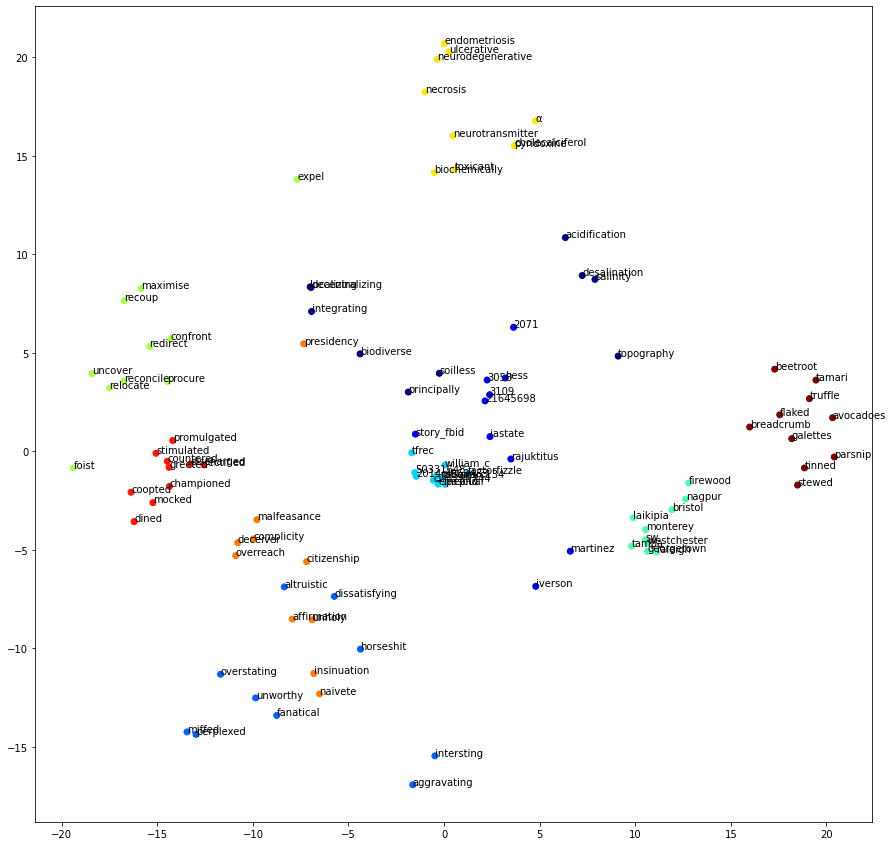

In [ ]:
# word2index = {token: token_idx for token_idx, token in enumerate(w2v_model.wv.index2word)}
plt.figure(figsize=(15,15))
word_idx = []
for i, c in enumerate(cluster_word_dict_sorted.keys()):
    # word_idx = []
    draw_words = [word[0] for word in cluster_word_dict_sorted[c][:num_plot]]
    for word in draw_words:
        idx = w2v_keyedvector.vocab[word].index
        word_idx.append(idx)
        # plt.scatter(vocab_emb[idx, 0], vocab_emb[idx, 1], c=colors[i], cmap='jet')
        plt.annotate(word, xy=(vocab_emb[idx, 0], vocab_emb[idx, 1]))
        # plt.text(vocab_emb[idx, 0], vocab_emb[idx, 1], word)
    # print(word_idx)
    # print(draw_words)
    # plt.scatter(vocab_emb[word_idx, 0], vocab_emb[word_idx, 1], c=[i]*num_plot, cmap='jet')

colors = []
# construct color array for all points
for i in range(num_clusters):
    colors += [i] * num_plot
plt.scatter(vocab_emb[word_idx, 0], vocab_emb[word_idx, 1], c=colors, cmap='jet')
plt.show()

# some other code for colored plot
# for i in range(X.shape[0]):
#     plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), fontdict={'weight': 'bold', 'size': 9})

# NMF

- different options w.r.t. documents
    - segment as document
    - sentence as document
    - whole comment as document
    - all comments in one product as document

# Clarity Scoring Function